In [65]:
# imports
import numpy as np
import sympy as sy
import re
import csv

import matplotlib.pyplot as plt
import matplotlib.colors as c
from matplotlib.ticker import PercentFormatter
from matplotlib import rcParams
import scipy.constants as pc
from sympy import *
from math import log10, floor
from math import *
import math

from scipy.optimize import curve_fit
from scipy.optimize import minimize

rcParams['font.size'] = 15
rcParams['font.weight'] = 'bold'
rcParams['text.usetex'] = True
rcParams['axes.grid'] = True
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams["xtick.minor.size"] =  4
rcParams["ytick.minor.size"] =  4
rcParams["xtick.minor.visible"] =  True
rcParams["ytick.minor.visible"] =  True

In [2]:
# Funktionen
def am(werte):
    return np.mean(werte)

def std(werte):
    summen_der_quadrate = 0
    for wert in werte:
        summen_der_quadrate+=(wert-am(werte))**2       
    return np.sqrt(summen_der_quadrate/(werte.size-1))

def stu(werte):
    return std(werte)/np.sqrt(werte.size)

def fehler(f, werte, unsicherheiten, variablen):
    zMax = 0
    for i in range(werte.size):
        dif = np.abs(sy.diff(f, variablen[i]))
        zMax += (dif * unsicherheiten[i])**2
    zMax = sqrt(zMax)
    for j in range(werte.size):
        zMax = sub(zMax, variablen[j], werte[j])
    return zMax

def fehlerMax(f, werte, unsicherheiten, variablen):
    zMax = 0
    for i in range(werte.size):
        dif = np.abs(sy.diff(f, variablen[i]))
        zMax += dif * unsicherheiten[i]
    for j in range(werte.size):
        zMax = sub(zMax, variablen[j], werte[j])
    return zMax

def groessterBeitrag(f, werte, unsicherheiten, variablen):
    zMax = 0
    zMaxArray = np.array([])
    for i in range (werte.size):
        zMax = (np.abs(sy.diff(f, variablen[i])) * unsicherheiten[i])
        for j in range(werte.size):
            zMax = sub(zMax, variablen[j], werte[j])
        x = np.array([zMax])
        zMaxArray = np.append(zMaxArray, x)
    return variablen[np.argmax(zMaxArray)], zMaxArray[np.argmax(zMaxArray)]

def sub(zMax, variable, wert):
    return zMax.subs([(variable, wert)])

def einfachGaussAdd(unsicherheiten, koeffizienten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (koeffizienten[i]*unsicherheiten[i])**2
    return sqrt(dz)

def einfachGaussMult(unsicherheiten, werte, exponenten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (exponenten[i]*unsicherheiten[i]/werte[i])**2
    return sqrt(dz)

def einfachGaussMultMax(unsicherheiten, werte, exponenten):
    max_a = 0
    num = -1
    for i in range (unsicherheiten.size):
        maxi = (exponenten[i]*unsicherheiten[i]/werte[i])**2
        if max_a <= maxi:
            max_a = maxi
            num = i
    return (max_a, num)

def vertraeglichkeit(am_1, am_2, stu_1, stu_2):
    return (np.abs(am_1-am_2)/(sqrt((stu_1**2)*(stu_2**2))))

def bestA(x, y):
    return (sum(x**2)*sum(y)-sum(x)*sum(x*y))/(x.size*sum(x**2)-sum(x)**2)

def bestB(x, y):
    return (x.size*sum(x*y)-sum(x)*sum(y))/(x.size*sum(x**2)-sum(x)**2)

def streuung(x, y):
    s = 0
    for i in range(x.size):
        s += (y[i]-(bestA(x, y)+bestB(x, y)*x[i]))**2
    return np.sqrt(s/(x.size-2))

def stuA(x, y):
    s = streuung(x, y)
    return s*np.sqrt(sum(x**2)/((x.size*sum(x**2)-sum(x)**2)))

def stuB(x, y):
    s = streuung(x, y)
    return s*np.sqrt(x.size/((x.size*sum(x**2)-sum(x)**2)))

def round_to_j(x,j):
    return round(x, (j-1)-int(floor(log10(abs(x)))))

def print_to_table(avgs, stds, rows, cols,
                   highlight_best=True,
                   max_is_best=True,
                   avg_format='{0:!>4.1f}',
                   std_format='{1:!<4.1f}',
                   file=None,
                   col_orientation='c'):
    # Find best values
    best_avg = {}
    if highlight_best:
        if max_is_best:
            for c in cols:
                idx = np.argmax(avgs[c], axis=0)
                best_avg[c] = idx
        else:
            for c in cols:
                idx = np.argmin(avgs[c], axis=0)
                best_avg[c] = idx

    # Header
    print_str = '\\begin{tabular}{l' + (" "+col_orientation) * len(cols) + '} \hline\n'
    for c in cols:
        print_str += ' & ' + c
    print_str += ' \\\\ \n \hline'

    # Content
    for m in range(len(rows)):
        row_name = rows[m]
        print_str += '\n{0}'.format(row_name)
        for c in cols:
            print_str += ' &\n '
            print_list = [avgs[c][m]]
            print_list += [stds[c][m]]
            if m == best_avg.get(c, None):
                print_str += ('$\mathbf{{'+ avg_format + ' \\pm ' + std_format + '}}$').format(*print_list)
            else:
                print_str += ('$'+ avg_format + ' \\pm ' + std_format + '$').format(*print_list)

        print_str += "\n \\vspace*{0.0mm} \\\\"
        print_str = print_str.replace('!', '\\phantom{0}')

    # Footer
    print_str += '\n \hline \n \end{tabular}'

    # Write output
    if file is None:
        print(print_str)
    else:
        with open(file, 'w') as f:
            f.write(print_str)

In [5]:
#
# Erinnerungen
#

#ax.plot(x, y, color='tab:bue', label=r'label')
#ax.scatter(x, y, color='tab:red', label=r'label')
#ax.errorbar(am_x, am_y, xerr=std_x, yerr=std_y, capsize='5', 
#            ecolor=['tab:blue','tab:red'], fmt='none', color='tab:blue', label=r'label')
# x = np.array([,])
# x.size
# x, y = symbols('x y')
# expr = x*y
# expr.subs([(x, wert_x), (y, wert_y)])

In [90]:
#
# DATEN EINLESEN
#

import pandas as pd

data = pd.read_csv('saegezahn_HM1508.csv', sep=',', header=None)

data = data.drop([0], axis=0)
time = data[0].to_numpy().astype(float) 
channelA = data[1].to_numpy().astype(float) 
channelB = data[2].to_numpy().astype(float) 

time = time[::2]   
channelA = channelA[::2]
channelB = channelB[::2]


In [302]:
#
# DATEN VERARBEITEN
#

# 0.02 0.034 12/29 20/29 12-94

# Anfangs und Endwert des Signals bestimmen
timeWindow = time[int(len(time)*11.5/29):int(len(time)*19.3/29)]  
channelBWindow = channelB[int(len(channelB)*11.5/29):int(len(channelB)*19.3/29)]  

# Abgeflachten Peaks aus Daten nehmen
timeWindowPeakAdjusted = timeWindow[109:]
timeWindowPeakAdjusted = np.concatenate((timeWindow[:30], timeWindowPeakAdjusted))
#timeWindowPeakAdjusted = timeWindowPeakAdjusted[:52]


channelBWindowPeakAdjusted = channelBWindow[109:]
channelBWindowPeakAdjusted = np.concatenate((channelBWindow[:30], channelBWindowPeakAdjusted))
#channelBWindowPeakAdjusted = channelBWindowPeakAdjusted[:52]

print(max(channelBWindowPeakAdjusted))

#fitParams = np.polyfit(timeWindowPeakAdjusted, channelBWindowPeakAdjusted, 3)
#fitData = timeWindow**3*fitParams[0] + timeWindow**2*fitParams[1] + timeWindow*fitParams[2] + fitParams[3]

guess_freq = 2940/(2*pi)
guess_amplitude = 3.10464
guess_phase = 0.15
guess_offset = -1

p0=[guess_freq, guess_amplitude,
    guess_phase, guess_offset]

# create the function we want to fit
def my_sin(x, freq, amplitude, phase, offset):
    return np.sin(x * freq + phase) * amplitude + offset

# now do the fit
fit = curve_fit(my_sin, timeWindowPeakAdjusted, channelBWindowPeakAdjusted, p0=p0)

# we'll use this to plot our first estimate. This might already be good enough for you
data_first_guess = my_sin(timeWindow, *p0)

# recreate the fitted curve using the optimized parameters
data_fit = my_sin(timeWindow, *fit[0])

print(max(data_fit))

3.10464
3.344379787505815


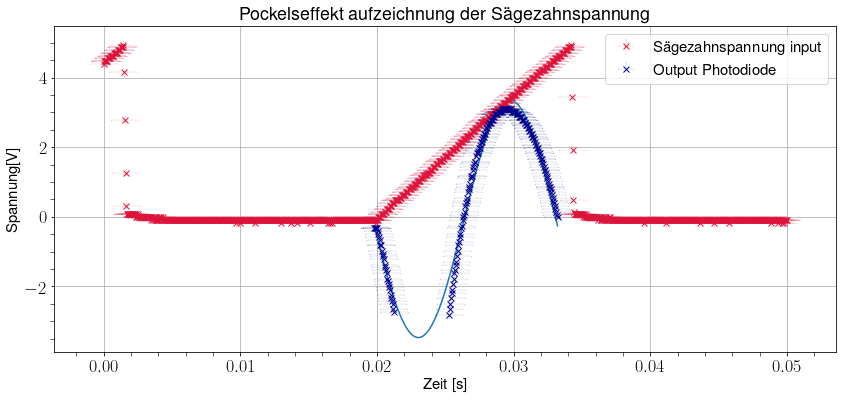

In [296]:
#
# DATEN PLOTTEN
#

fig, ax = plt.subplots(1, 1, figsize=(14,6))

#ax[0 ,0].hist(bins, bins=nBins, histtype='step', color='darkblue', 
           ##weights=dataSodium, label=r'Bins for $^{22}$Na')


ax.errorbar(time, channelA, xerr=0.001, yerr=0.1, capsize=0.1, elinewidth=.1, fmt='x', color="crimson", label=r'Sägezahnspannung input')
ax.errorbar(timeWindowPeakAdjusted, channelBWindowPeakAdjusted, xerr=0.001, yerr=0.1, capsize=0.1, elinewidth=.1, fmt='x', color="darkblue", label=r'Output Photodiode')
ax.plot(timeWindow, data_fit)

#ax.scatter(time, channelA, color="crimson")


#ax[0, 0].set_xlim([0, nBins])
#ax[0, 0].set_yscale('log')


ax.set(title=r'Pockelseffekt aufzeichnung der Sägezahnspannung')
ax.set(xlabel=r'Zeit [s]', ylabel=r'Spannung[V]')


ax.legend()

#fig.savefig("name.pdf")

In [ ]:
positivPeaks = []

In [ ]:
def latextable(werte,      #Alle Werte als numpy Array von Wertearrays (dtype=float)
               wertenamen, #numpy Array von Stringnamen. Selbe Reihenfolge wie 'werte'
               fehler,     #Alle Werte als numpy Array von Wertearrays (dtype=float). Selbe Reihenfolge wie 'werte'
               einheiten,  #numpy Array von Stringnamen. Selbe Reihenfolge wie 'werte'
               senkrecht,  #boolean: True: Werte einer Variable vertikal ausgerichtet (!maximal 5 verschiedene Wertenamen!); False: Werte einer Variable horizontal ausgerichtet
               doppelt,    #boolean: True: wertenamen oben UND links (wertenamen als Array von Stringarrays, [0]-oben;[1]-links);False: wertenamen oben ODER links (je nach Orientierung von 'senkrecht')
               label,      #label als String (ohne tab:)
               caption,    #caption als rString
               dicke       #Integer, roughly wieviele Zeichen in einer Zeile bei horizontaler Ausrichtung; ca 25 angenehm zu lesen und Standard
              ):
    
    if doppelt:
        if senkrecht:                 #senkrechte Tabelle mit zweifach abhängigen Werten
            print_str ='\\begin{table}[H] \n \t \\centering \n \t \\sisetup{separate-uncertainty} \n\t \\resizebox{' f'{np.round_(0.2*len(wertenamen),1)}' '\\textwidth}{!}{\n\t\t' #begintable
            print_str += '\\begin{tabular}{@{}r|'
            #tableformat
            sigfigs_nach_komma = np.array([])
            for c in range(len(werte)):
                idmax = np.argmax(werte[c], axis=0)
                idmin = np.argmin(werte[c], axis=0)
                sigfigs_nach_komma = np.append(sigfigs_nach_komma,sigfigs - (floor(log10(werte[c][idmin])) + 1))
                if sigfigs_nach_komma[c] > 0:
                    print_str += r'S[table-format=' f'{floor(log10(werte[c][idmax])) + 1}' r'.' f'{int(sigfigs_nach_komma[c])}' '(' f'{sigfigs}'  r')]'
                else:
                    print_str += r'S[table-format=' f'{floor(log10(werte[c][idmax])) + 1}' '(' f'{sigfigs}'  r')]'
            print_str += '|@{}}\n\t\t\\toprule\n\t\t'
            #Überschriften
            for c in range(len(werte)):
                print_str += '& \\text{'f'{wertenamen[0][c]}''}\\text{'f'{einheiten[1][c]}' '}'
            print_str += '\\\\\n\t\t\\midrule\n\t\t'
            wertek = np.stack((werte),axis = -1)
            fehlerk = np.stack((fehler),axis = -1)
            #mit Werten füllen
            for c in range(len(wertek)):
                print_str += f'{wertenamen[1][c]} {einheiten[1][c]}'
                for i in range(fehlerk[c].size):
                    fehlerc = np.array2string(fehlerk[c][i])
                    punktf = fehlerc.find('.')
                    sigfag = 0
                    fehlerc = fehlerc.replace('.','')
                    for t in range(len(fehlerc)):
                        if fehlerc[t] == '0':
                            sigfag += 1
                            fehlerc = fehlerc[1:]
                        elif fehlerc[t] == '1':
                            sigfag +=2
                            fehlerk[c][i] = int(fehlerc[:sigfag])
                            if sigfag >= punktf:
                                sigfag +=1
                            break
                        else:
                            sigfag +=1
                            fehlerk[c][i] = int(fehlerc[:sigfag])
                            if sigfag >= punktf:
                                sigfag +=1
                            break
                    wertec = np.array2string(wertek[c][i])
                    punktw = wertec.find('.')
                    if sigfag < punktw:
                        wertek[c][i] = int(wertec[:punktw-punktf+sigfag])
                    else:
                        wertek[c][i] = float(wertec[:sigfag])
                for i in range(wertek[c].size):
                    if wertek[c][i] == int(wertek[c][i]):
                        print_str += r' & ' f'{int(wertek[c][i])}' r'(' f'{int(fehlerk[c][i])}' r')'
                    else:
                        if sigfigs_nach_komma[c] > 0:
                            print_str += r' & ' f'{wertek[c][i]}' r'(' f'{int(fehlerk[c][i])}' r')'
                        else:
                            print_str += r' & ' f'{int(wertek[c][i])}' r'(' f'{int(fehlerk[c][i])}' r')'
                print_str += ' \\\\\n\t\t'
        else:                         #waagerechte Tabelle mit zweifach abhängigen Werten
            print_str ='\\begin{table}[H] \n \t \\centering \n \t \\sisetup{separate-uncertainty} \n\t \\resizebox{\\textwidth}{!}{\n\t\t' #begintable
            print_str += '\\begin{tabular}{@{}r|'
            #überprüfen obs in eine Zeile passt
            laenge_alle = np.array([])
            for c in range(len(werte)):
                laenge = len(wertenamen[c])
                for i in range(werte[c].size):
                    if werte[c][i] != 0:
                        laenge += floor(log10(np.abs(werte[c][i]))) + 1 + sigfigs
                laenge_alle = np.append(laenge_alle, laenge)
            laengste = np.argmax(laenge_alle, axis=0)
            wertesplit = np.array([])
            zeilen, rest = modul(dicke,int(laenge_alle[laengste]))
            #wenns nicht in eine Zeile passt:
            if (zeilen > 0):
                print_str = 'ERROR+++ACHTUNG+++ERROR\nZeilen zu lang! Entweder Orientierung ändern, oder dicke vergrößern\ERROR+++Achtung+++ERROR'
                return print_str
            else:
                sigfigs_nach_komma = np.array([])
                for i in range(werte[0].size):
                    reihenwerte = np.array([])
                    for c in range(len(werte)):
                        reihenwerte = np.append(reihenwerte, werte[c][i])
                    idmax = np.argmax(reihenwerte, axis=0)
                    idmin = np.argmin(reihenwerte, axis=0)
                    sigfigs_nach_komma = np.append(sigfigs - (floor(log10(reihenwerte[idmin])) + 1))
                    if sigfigs_nach_komma[i] > 0:
                        print_str += r'S[table-format=' f'{floor(log10(reihenwerte[idmax])) + 1}' r'.' f'{int(sigfigs_nach_komma[i])}' '(' f'{sigfigs}'  r')]'
                    else:
                        print_str += r'S[table-format=' f'{floor(log10(reihenwerte[idmax])) + 1}' '(' f'{sigfigs}'  r')]'
                print_str += '@{}}\n\t\t\\toprule\n\t\t'
                for c in range(len(werte)):
                    print_str += '& \\text{'f'{wertenamen[0][c]}''}\\text{'f'{einheiten[1][c]}' '} '
                print_str += '\n\t\t\\midrule\n\t\t'
                #Einfügen der einzelnen Zeilen
                for c in range(len(werte)):
                    print_str += wertenamen[c] + einheiten[c]
                    for i in range(fehler[1][c].size):
                        fehlerc = np.array2string(fehler[c][i])
                        punktf = fehlerc.find('.')
                        sigfag = 0
                        fehlerc = fehlerc.replace('.','')
                        for t in range(len(fehlerc)):
                            if fehlerc[t] == '0':
                                sigfag += 1
                                fehlerc = fehlerc[1:]
                            elif fehlerc[t] == '1':
                                sigfag +=2
                                fehler[c][i] = int(fehlerc[:sigfag])
                                if sigfag >= punktf:
                                    sigfag +=1
                                break
                            else:
                                sigfag +=1
                                fehler[c][i] = int(fehlerc[:sigfag])
                                if sigfag >= punktf:
                                    sigfag +=1
                                break
                        wertec = np.array2string(werte[c][i])
                        punktw = wertec.find('.')
                        if sigfag < punktw:
                            werte[c][i] = int(wertec[:punktw-punktf+sigfag])
                        else:
                            werte[c][i] = float(wertec[:sigfag])
                    for i in range(werte[c].size):
                        if werte[c][i] == int(werte[c][i]):
                            print_str += r' & ' f'{int(werte[c][i])}' r'(' f'{int(fehler[c][i])}' r')'
                        else:
                            if sigfigs_nach_komma[c] > 0:
                                print_str += r' & ' f'{werte[c][i]}' r'(' f'{int(fehler[c][i])}' r')'
                            else:
                                print_str += r' & ' f'{int(werte[c][i])}' r'(' f'{int(fehler[c][i])}' r')'
                    print_str += ' \\\\\n\t\t'
    else:
        if senkrecht:                 #senkrechte Tabelle mit einfach abhängigen Werten
            print_str ='\\begin{table}[H] \n \t \\centering \n \t \\sisetup{separate-uncertainty} \n\t \\resizebox{' f'{np.round_(0.2*len(wertenamen),1)}' '\\textwidth}{!}{\n\t\t' #begintable
            print_str += '\\begin{tabular}{@{}|'
            #tableformat
            sigfigs_nach_komma = np.array([])
            for c in range(len(werte)):
                idmax = np.argmax(werte[c], axis=0)
                idmin = np.argmin(werte[c], axis=0)
                sigfigs_nach_komma = np.append(sigfigs_nach_komma,sigfigs - (floor(log10(werte[c][idmin])) + 1))
                if c != 0:
                    print_str += '|'
                if sigfigs_nach_komma[c] > 0:
                    print_str += r'S[table-format=' f'{floor(log10(werte[c][idmax])) + 1}' r'.' f'{int(sigfigs_nach_komma[c])}' '(' f'{sigfigs}'  r')]'
                else:
                    print_str += r'S[table-format=' f'{floor(log10(werte[c][idmax])) + 1}' '(' f'{sigfigs}'  r')]'
            print_str += '|@{}}\n\t\t'
            #Überschriften
            for c in range(len(werte)):
                print_str += '\\text{'f'{wertenamen[c]}''}\\text{'f'{einheiten[c]}' '} & '
            print_str += '\n\t\t\\hline\n\t\t'
            wertek = np.stack((werte),axis = -1)
            fehlerk = np.stack((fehler),axis = -1)
            #mit Werten füllen
            for c in range(len(wertek)):
                for i in range(fehlerk[c].size):
                    fehlerc = np.array2string(fehlerk[c][i])
                    punktf = fehlerc.find('.')
                    sigfag = 0
                    fehlerc = fehlerc.replace('.','')
                    for t in range(len(fehlerc)):
                        if fehlerc[t] == '0':
                            sigfag += 1
                            fehlerc = fehlerc[1:]
                        elif fehlerc[t] == '1':
                            sigfag +=2
                            fehlerk[c][i] = int(fehlerc[:sigfag])
                            if sigfag >= punktf:
                                sigfag +=1
                            break
                        else:
                            sigfag +=1
                            fehlerk[c][i] = int(fehlerc[:sigfag])
                            if sigfag >= punktf:
                                sigfag +=1
                            break
                    wertec = np.array2string(wertek[c][i])
                    punktw = wertec.find('.')
                    if sigfag < punktw:
                        wertek[c][i] = int(wertec[:punktw-punktf+sigfag])
                    else:
                        wertek[c][i] = float(wertec[:sigfag])
                for i in range(wertek[c].size):
                    if wertek[c][i] == int(wertek[c][i]):
                        print_str += r' & ' f'{int(wertek[c][i])}' r'(' f'{int(fehlerk[c][i])}' r')'
                    else:
                        if sigfigs_nach_komma[c] > 0:
                            print_str += r' & ' f'{wertek[c][i]}' r'(' f'{int(fehlerk[c][i])}' r')'
                        else:
                            print_str += r' & ' f'{int(wertek[c][i])}' r'(' f'{int(fehlerk[c][i])}' r')'
                print_str += ' \\\\\n\t\t'
        
        
        else:                         #waagerechte Tabelle mit einfach abhängigen Werten
            print_str ='\\begin{table}[H] \n \t \\centering \n \t \\sisetup{separate-uncertainty} \n\t \\resizebox{\\textwidth}{!}{\n\t\t' #begintable
            print_str += '\\begin{tabular}{@{}r|'
            #überprüfen obs in eine Zeile passt
            laenge_alle = np.array([])
            for c in range(len(werte)):
                laenge = len(wertenamen[c])
                for i in range(werte[c].size):
                    if werte[c][i] != 0:
                        laenge += floor(log10(np.abs(werte[c][i]))) + 1 + sigfigs
                laenge_alle = np.append(laenge_alle, laenge)
            laengste = np.argmax(laenge_alle, axis=0)
            wertesplit = np.array([])
            zeilen, rest = modul(dicke,int(laenge_alle[laengste]))
            #wenns nicht in eine Zeile passt:
            if (zeilen > 0):
                if len(werte[0])/zeilen>int(len(werte[0])/zeilen):
                    wertek = np.zeros((len(werte),zeilen,int(len(werte[0])/zeilen)+1)).tolist()
                    fehlerk = np.zeros((len(werte),zeilen,int(len(werte[0])/zeilen)+1)).tolist()
                    for r in range((int(len(werte[0])/zeilen))):
                        wertek[c][zeilen-(int(len(werte[0])/zeilen))+r].pop(int(len(werte[0])/zeilen))
                        fehlerk[c][zeilen-(int(len(werte[0])/zeilen))+r].pop(int(len(werte[0])/zeilen))
                    wertek = np.asarray(wertek)
                    fehlerk = np.asarray(fehlerk)
                else:
                    wertek = np.zeros((len(werte),zeilen,int(len(werte[0])/zeilen)))
                    fehlerk = np.zeros((len(werte),zeilen,int(len(werte[0])/zeilen)))
                for k in range(len(werte)):
                    wertek[k] = np.array_split(werte[k], zeilen)
                    fehlerk[k] = np.array_split(fehler[k], zeilen)
                    
                werte = wertek
                fehler = fehlerk
                for j in range(zeilen):
                    sigfigs_nach_komma = np.array([])
                    for i in range(werte[0][j].size):
                        #Formatierung nach signifikanten Stellen vor und nach dem Komma plus Fehler
                        reihenwerte = np.array([])
                        for c in range(len(werte)):
                            for l in range(len(werte[c])):
                                if len(werte[c][l])>i:
                                    reihenwerte = np.append(reihenwerte, werte[c][l][i])
                        idmax = np.argmax(reihenwerte, axis=0)
                        idmin = np.argmin(reihenwerte, axis=0)
                        #print(reihenwerte[idmin])
                        sigfigs_nach_komma = np.append(sigfigs_nach_komma,sigfigs - (floor(log10(reihenwerte[idmin])) + 1))
                        if j == 0:
                            if sigfigs_nach_komma[i] > 0:
                                print_str += r'S[table-format=' f'{floor(log10(reihenwerte[idmax])) + 2}' r'.' f'{int(sigfigs_nach_komma[i])}' '(' f'{sigfigs}'  r')]'
                            else:
                                print_str += r'S[table-format=' f'{floor(log10(reihenwerte[idmax])) + 2}' '(' f'{sigfigs}'  r')]'
                    if j == 0:
                        print_str += '@{}}\n\t\t\\toprule\n\t\t'
                    else:
                        print_str += '\\midrule \n\t\t'
                    #Einfügen der einzelnen Zeilen
                    for c in range(len(werte)):
                        print_str += wertenamen[c] + einheiten[c]
                        for i in range(fehler[c][j].size):
                            fehlerc = np.array2string(fehler[c][j][i])
                            punktf = fehlerc.find('.')
                            sigfag = 0
                            fehlerc = fehlerc.replace('.','')
                            for t in range(len(fehlerc)):
                                if fehlerc[t] == '0':
                                    sigfag += 1
                                    fehlerc = fehlerc[1:]
                                elif fehlerc[t] == '1':
                                    sigfag +=2
                                    fehler[c][j][i] = int(fehlerc[:sigfag])
                                    if sigfag >= punktf:
                                        sigfag +=1
                                    break
                                else:
                                    sigfag +=1
                                    fehler[c][j][i] = int(fehlerc[:sigfag])
                                    if sigfag >= punktf:
                                        sigfag +=1
                                    break
                            wertec = np.array2string(werte[c][j][i])
                            punktw = wertec.find('.')
                            if sigfag < punktw:
                                werte[c][j][i] = int(wertec[:punktw-punktf+sigfag])
                            else:
                                werte[c][j][i] = float(wertec[:sigfag])
                        for i in range(werte[c][j].size):
                            if werte[c][j][i] == int(werte[c][j][i]):
                                print_str += r' & \text{(}' f'{int(werte[c][j][i])}' r'(' f'{int(fehler[c][j][i])}' r')\text{)}'
                            else:
                                if sigfigs_nach_komma[c] > 0:
                                    print_str += r' & \text{(}' f'{werte[c][j][i]}' r'(' f'{int(fehler[c][j][i])}' r')\text{)}'
                                else:
                                    print_str += r' & \text{(}' f'{int(werte[c][j][i])}' r'(' f'{int(fehler[c][j][i])}' r')\text{)}'
                        print_str += ' \\\\\n\t\t'
                    print_str += '\n\t\t'
            else:
                sigfigs_nach_komma = np.array([])
                for i in range(werte[0].size):
                    reihenwerte = np.array([])
                    for c in range(len(werte)):
                        reihenwerte = np.append(reihenwerte, werte[c][i])
                    idmax = np.argmax(reihenwerte, axis=0)
                    idmin = np.argmin(reihenwerte, axis=0)
                    sigfigs_nach_komma = np.append(sigfigs - (floor(log10(reihenwerte[idmin])) + 1))
                    if sigfigs_nach_komma[i] > 0:
                        print_str += r'S[table-format=' f'{floor(log10(reihenwerte[idmax])) + 1}' r'.' f'{sigfigs_nach_komma}' '(' f'{sigfigs}'  r')]'
                    else:
                        print_str += r'S[table-format=' f'{floor(log10(reihenwerte[idmax])) + 1}' '(' f'{sigfigs}'  r')]'
                print_str += '@{}}\n\t\t\\toprule\n\t\t'
                #Einfügen der einzelnen Zeilen
                for c in range(len(werte)):
                    print_str += wertenamen[c] + einheiten[c]
                    for i in range(fehler[c].size):
                        fehlerc = np.array2string(fehler[c][i])
                        punktf = fehlerc.find('.')
                        sigfag = 0
                        fehlerc = fehlerc.replace('.','')
                        for t in range(len(fehlerc)):
                            if fehlerc[t] == '0':
                                sigfag += 1
                                fehlerc = fehlerc[1:]
                            elif fehlerc[t] == '1':
                                sigfag +=2
                                fehler[c][i] = int(fehlerc[:sigfag])
                                if sigfag >= punktf:
                                    sigfag +=1
                                break
                            else:
                                sigfag +=1
                                fehler[c][i] = int(fehlerc[:sigfag])
                                if sigfag >= punktf:
                                    sigfag +=1
                                break
                        wertec = np.array2string(werte[c][i])
                        punktw = wertec.find('.')
                        if sigfag < punktw:
                            werte[c][i] = int(wertec[:punktw-punktf+sigfag])
                        else:
                            werte[c][i] = float(wertec[:sigfag])
                    for i in range(werte[c].size):
                        if werte[c][i] == int(werte[c][i]):
                            print_str += r' & ' f'{int(werte[c][i])}' r'(' f'{int(fehler[c][i])}' r')'
                        else:
                            if sigfigs_nach_komma[c] > 0:
                                print_str += r' & ' f'{werte[c][i]}' r'(' f'{int(fehler[c][i])}' r')'
                            else:
                                print_str += r' & ' f'{int(werte[c][i])}' r'(' f'{int(fehler[c][i])}' r')'
                    print_str += ' \\\\\n\t\t'
    print_str += '\\midrule\n\t\t\\bottomrule\n\t\\end{tabular}\n\t}\n\t\\label{tab:' + label + '}\n\t\caption{' + caption + '}\n\\end{table}'
    return print_str